[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dev-Khant/English-to-Hindi-Translation/blob/main/English_To_Hindi_Translation.ipynb)

### This [article](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/) by François Chollet helped a lot to understand the implementation of Transformers.

## Importing Libraries

In [ ]:
# Importing libraries
import os
import pickle
import pandas as pd
import numpy as np
import random
import string
import re
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import TextVectorization

import warnings
warnings.filterwarnings("ignore")

## Defining Parameters

In [ ]:
# Tranining Hyperparameters
batch_size = 64

# Model Hyperparameters
embed_dim = 128
num_heads = 10
latent_dim = 2048
vocab_size = 20000
sequence_length = 20
dropout = 0.2

## Defining Functions

In [ ]:
def preprocess_text(df):
    # Lowercase the characters
    df["english_sent"] = df["english_sent"].apply(lambda x : x.lower())
    df["hindi_sent"] = df["hindi_sent"].apply(lambda x : x.lower())

    # Rmoving URLs
    df["english_sent"] = df["english_sent"].apply(lambda x : re.sub(r"http\S+", "", x))
    df["hindi_sent"] = df["hindi_sent"].apply(lambda x : re.sub(r"http\S+", "", x))

    # Removing digits
    remove_digits = str.maketrans("", "",string.digits)
    df["english_sent"] = df["english_sent"].apply(lambda x : x.translate(remove_digits))
    df["hindi_sent"] = df["hindi_sent"].apply(lambda x : x.translate(remove_digits))
    df["hindi_sent"] = df["hindi_sent"].apply(lambda x : re.sub("[a-zA-z२३०८१५७९४६]", "", x))

    # Remove special characters
    special = set(string.punctuation)
    df['english_sent'] = df['english_sent'].apply(lambda x : ''.join(ch for ch in x if ch not in special))
    df['hindi_sent'] = df['hindi_sent'].apply(lambda x : ''.join(ch for ch in x if ch not in special))

    # Remove quotes
    df['english_sent'] = df['english_sent'].apply(lambda x: re.sub("'", '', x))
    df['hindi_sent'] = df['hindi_sent'].apply(lambda x: re.sub("'", '', x))
    
    # Remove extra spaces
    df['english_sent'] = df['english_sent'].apply(lambda x : x.strip())
    df['hindi_sent'] = df['hindi_sent'].apply(lambda x : x.strip())
    df['english_sent'] = df['english_sent'].apply(lambda x : re.sub(" +"," ",x))
    df['hindi_sent'] = df['hindi_sent'].apply(lambda x : re.sub(" +"," ",x))
    

    # Add [start] and [end] tags
    df["hindi_sent"] = df["hindi_sent"].apply(lambda x : "[start] " + x + " [end]")

In [ ]:
def decode_sequence(input_sentence):
    hindi_vocab = hindi_vectorization.get_vocabulary()
    hindi_index_lookup = dict(zip(range(len(hindi_vocab)), hindi_vocab))
    max_decoded_sentence_length = 20
    
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = hindi_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = hindi_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    
    return decoded_sentence[8:-5] # Removing [start] and [end] tokens

In [ ]:
# For creating Dataset
def format_dataset(eng, hin):
    eng = eng_vectorization(eng)
    hindi = hindi_vectorization(hin)
    return ({"encoder_inputs" : eng, "decoder_inputs" : hindi[:, :-1],}, hindi[:, 1:])


def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["english_sent"].values, df["hindi_sent"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


## Reading Data & Preprocessing Text

In [ ]:
df = pd.read_csv("../input/english-to-hindi-text-corpus/Hindi_English_Truncated_Corpus.csv")
df.drop(["source"], axis=1, inplace = True)
df.dropna(axis = 0, inplace = True)
df.rename(columns = {"english_sentence" : "english_sent", "hindi_sentence" : "hindi_sent"}, inplace = True)
df.head()

,english_sent,hindi_sent
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
# Preprocess text
preprocess_text(df)

# Drop rows with Null values
df.drop(df[df["english_sent"] == " "].index, inplace = True)
df.drop(df[df["hindi_sent"] == "[start]  [end]"].index, inplace = True)

In [ ]:
# Find Sentence Length
df["eng_sent_length"] = df["english_sent"].apply(lambda x : len(x.split(' ')))
df["hindi_sent_length"] = df["hindi_sent"].apply(lambda x : len(x.split(' ')))

In [ ]:
# Get sentences with specific length 20
df = df[df["eng_sent_length"] <= 20]
df = df[df["hindi_sent_length"] <= 20]

# Take 85K records for training
df = df.sample(n = 85000, random_state = 2048)
df = df.reset_index(drop = True)

# Defining train, valid, test
train = df.iloc[:80000]
val = df.iloc[80000:84500]
test = df.iloc[84500:]

## Tokenizing Sentences


In [ ]:
# Using TextVectorization to create sentence vectors
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", output_sequence_length = sequence_length
    )

hindi_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", output_sequence_length = sequence_length + 1, standardize=custom_standardization
)

eng_vectorization.adapt(df["english_sent"].values)
hindi_vectorization.adapt(df["hindi_sent"].values)

2021-12-18 08:32:01.231468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 08:32:01.315671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 08:32:01.316413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 08:32:01.317529: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
# Savng parameters and weights of both vectorizer
pickle.dump({'config': eng_vectorization.get_config(),
             'weights': eng_vectorization.get_weights()}
            , open("eng_vectorizer.pkl", "wb"))

pickle.dump({'config': hindi_vectorization.get_config(),
             'weights': hindi_vectorization.get_weights()}
            , open("hindi_vectorizer.pkl", "wb"))

## Creating Dataset


In [ ]:
train_ds = make_dataset(train)
val_ds = make_dataset(val)

## Creating Model

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_len, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.sequence_len = sequence_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_embedding = layers.Embedding(
            input_dim = vocab_size, output_dim = embed_dim
        )
        self.position_embedding = layers.Embedding(
            input_dim = sequence_len, output_dim = embed_dim
        )

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start = 0, limit = length, delta = 1)
        embedded_tokens = self.token_embedding(inputs)
        embedded_positions = self.position_embedding(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, dropout,**kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.attention = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim
        )
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.layer_ffn = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), 
             layers.Dropout(dropout),
             layers.Dense(embed_dim),]
            )
        self.supports_masking = True
    
    def call(self, inputs, mask = None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

        attention_output = self.attention(
            query = inputs, value = inputs, key = inputs, attention_mask = padding_mask
        )
        ffn_input = self.layer_norm1(inputs + attention_output)
        ffn_output = self.layer_ffn(ffn_input)
        return self.layer_norm2(ffn_input + ffn_output)

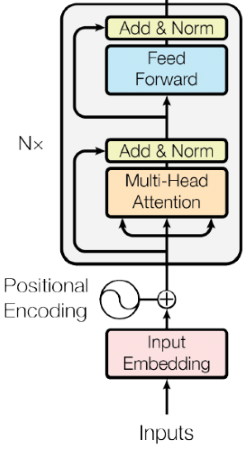

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, sropout,**kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.attention1 = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim
        )
        self.attention2 = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim
        )
        self.layer_ffn = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"),
             layers.Dropout(dropout),
             layers.Dense(embed_dim),]
        )
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.layer_norm3 = layers.LayerNormalization()

        self.supports_masking = True
    
    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        attention_output1 = self.attention1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask 
        )
        out1 = self.layer_norm1(inputs + attention_output1)

        attention_output2 = self.attention2(
            query = out1, value = encoder_outputs, key = encoder_outputs, attention_mask = padding_mask
        )
        out2 = self.layer_norm2(out1 + attention_output2)

        ffn_output = self.layer_ffn(out2)
        return self.layer_norm3(out2 + ffn_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

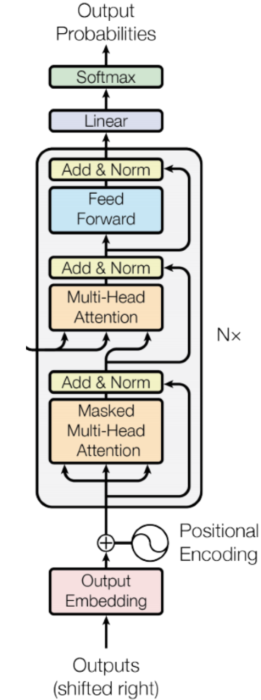

In [ ]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads, dropout,name="encoder_1")(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads, dropout,name="decoder_1")(x, encoded_seq_inputs)
x = layers.Dropout(0.4)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

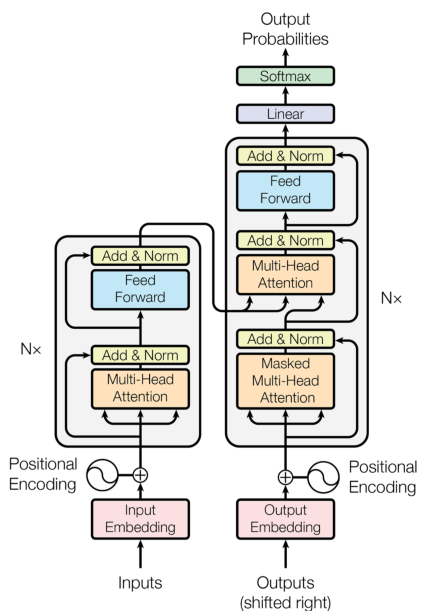

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 128)    2562560     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_1 (TransformerEncoder)  (None, None, 128)    1186304     positional_embedding[0][0]       
________________________________________________________________________________________

## Training Model

In [ ]:
# Defining callback functions
early_stopping = EarlyStopping(patience = 5,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Compiling model
transformer.compile(
    optimizer = "adam", 
    loss="sparse_categorical_crossentropy", 
    metrics = ["accuracy"]
)

# Training model
transformer.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks = [early_stopping, reduce_lr])

Epoch 1/50
   1/1250 [..............................] - ETA: 1:36:33 - loss: 5.3314 - accuracy: 0.0000e+00

2021-12-18 08:32:20.468230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 78s 59ms/step - loss: 2.9369 - accuracy: 0.2729 - val_loss: 2.5078 - val_accuracy: 0.3342
Epoch 2/50
1250/1250 [==============================] - 73s 58ms/step - loss: 2.3666 - accuracy: 0.3527 - val_loss: 2.2031 - val_accuracy: 0.3831
Epoch 3/50
1250/1250 [==============================] - 73s 58ms/step - loss: 2.0359 - accuracy: 0.4061 - val_loss: 2.0304 - val_accuracy: 0.4133
Epoch 4/50
1250/1250 [==============================] - 73s 58ms/step - loss: 1.8031 - accuracy: 0.4492 - val_loss: 1.9274 - val_accuracy: 0.4414
Epoch 5/50
1250/1250 [==============================] - 73s 58ms/step - loss: 1.6343 - accuracy: 0.4837 - val_loss: 1.8910 - val_accuracy: 0.4568
Epoch 6/50
1250/1250 [==============================] - 73s 58ms/step - loss: 1.5066 - accuracy: 0.5110 - val_loss: 1.8800 - val_accuracy: 0.4659
Epoch 7/50
1250/1250 [==============================] - 74s 59ms/step - loss: 1.4055 - accuracy: 0.5330 - val_loss: 1.8910 - val_accura

In [ ]:
# Saving weights of model
transformer.save_weights("eng-hin.h5")

## Testing Model & Calculating BLEU Score

In [ ]:
# Sample for testing
eng = "how are you"
print("English Sentence : ",eng)
print("Translated Sentence : ",decode_sequence(eng))

English Sentence :  how are you
Translated Sentence :  आप कैसे हैं 


In [ ]:
# Calculating BLEU score for test data
eng = test["english_sent"].values
original = test["hindi_sent"].values

translated = [decode_sequence(sent) for sent in eng]
bleu = 0

for i in range(test.shape[0]):
    bleu += sentence_bleu([original[i].split()], translated[i].split(), weights = (0.5, 0.5))

print("BLEU score is : ", bleu / test.shape[0])

BLEU score is :  0.24145048632377344
